In [1]:
!pip install pennylane

In [2]:
import time
import os
import copy
import random
import re
import numpy
import pandas as pd

#PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

#Pennylane
import pennylane as qml
from pennylane import numpy as np

np.random.seed(42)

import cv2
from PIL import Image
import matplotlib.pyplot as plt

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

#OpenMP: number of parallel threads
os.environ["OMP_NUM_THREADS"] = "1"

In [4]:
data_dir = './dataset'

In [5]:
n_qubits = 6                # Number of qubits
step = 0.0025               # Learning rate
batch_size = 50             # Number of samples for each training step
num_epochs = 33             # Number of training epochs
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [6]:
dev = qml.device("default.qubit", wires = n_qubits)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
# device = torch.device("cpu")

device(type='cuda', index=0)

In [8]:
data_transforms = {
    "train" : transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val" : transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test" : transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [9]:
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x:len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

In [10]:
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=batch_size, shuffle = True)
    for x in ["train", "validation"]
}

def imshow(inp, title = None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Variational quantum circuit

In [11]:
def H_layer(nqubits):
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
    
    
def RY_layer(w):
    for idx,element in enumerate(w):
        qml.RY(element, wires=idx)
        
        
def entangling_layer(nqubits):
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [12]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [13]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 8)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [14]:
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False

# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

In [15]:
criterion = nn.CrossEntropyLoss()

In [16]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

In [17]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=13, gamma=gamma_lr_scheduler
)

In [18]:
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            if phase == "train":
              train_loss.append(epoch_loss)
              train_accuracy.append(epoch_acc)
            else:
              val_loss.append(epoch_loss)
              val_accuracy.append(epoch_acc)
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model

In [20]:
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

Training started:


/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:239.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


Phase: train Epoch: 1/33 Loss: 1.8572 Acc: 0.2876        
Phase: validation Epoch: 1/33 Loss: 1.6876 Acc: 0.3558        
Phase: train Epoch: 2/33 Loss: 1.5081 Acc: 0.5508        
Phase: validation Epoch: 2/33 Loss: 1.3488 Acc: 0.6779        
Phase: train Epoch: 3/33 Loss: 1.3334 Acc: 0.6447        
Phase: validation Epoch: 3/33 Loss: 1.2183 Acc: 0.7356        
Phase: train Epoch: 4/33 Loss: 1.1708 Acc: 0.7411        
Phase: validation Epoch: 4/33 Loss: 1.2245 Acc: 0.6731        
Phase: train Epoch: 5/33 Loss: 1.2781 Acc: 0.6655        
Phase: validation Epoch: 5/33 Loss: 1.0829 Acc: 0.7788        
Phase: train Epoch: 6/33 Loss: 1.0618 Acc: 0.7402        
Phase: validation Epoch: 6/33 Loss: 1.0545 Acc: 0.7212        
Phase: train Epoch: 7/33 Loss: 1.0332 Acc: 0.6811        
Phase: validation Epoch: 7/33 Loss: 0.9458 Acc: 0.8077        
Phase: train Epoch: 8/33 Loss: 0.8713 Acc: 0.7941        
Phase: validation Epoch: 8/33 Loss: 0.9171 Acc: 0.7981        
Phase: train Epoch: 9/33 Loss: 0

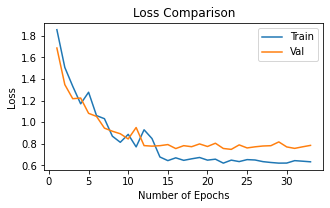

In [22]:
plt.figure(figsize=(5, 2.7))
plt.plot([i for i in range(1, num_epochs + 1)], train_loss, label='Train')
plt.plot([i for i in range(1, num_epochs + 1)], val_loss, label='Val')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title("Loss Comparison")
plt.legend()

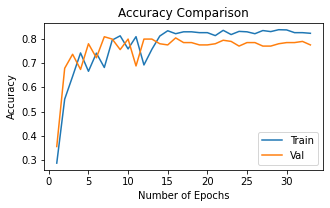

In [23]:
plt.figure(figsize=(5, 2.7))
plt.plot([i for i in range(1, num_epochs + 1)], train_accuracy, label='Train')
plt.plot([i for i in range(1, num_epochs + 1)], val_accuracy, label='Val') 
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy Comparison")
plt.legend();

In [24]:
def visualize_model(model, num_images=10, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 1, 1, images_so_far)
                ax.axis("off")
                ax.set_title(f"Pred = {class_names[preds[j]]}, Actual = {class_names[labels[j]]}")
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

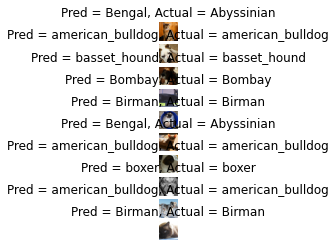

In [25]:
visualize_model(model_hybrid, num_images=10)
plt.show()

In [26]:
torch.save(model_hybrid.state_dict(), './model_hybrid.pt')

In [27]:
summary(model_hybrid, (3,255,255))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,